In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils as np_utils
import tensorflow_text as text

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from summa.summarizer import summarize
import re

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.4.0
Eager mode:  True
Hub version:  0.11.0
GPU is available


In [3]:
# Read file
data = pd.read_csv('../datasets/IMDB Dataset.csv',
                   encoding='ISO-8859-1')

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.sentiment.unique()

array(['positive', 'negative'], dtype=object)

### EDA

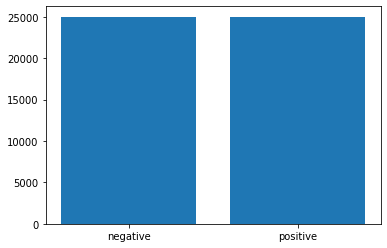

In [6]:
# Distribution of data under target classes
classes = data.sentiment.unique()
counts = []

for i in classes:
    count = len(data[data.sentiment==i])
    counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

In [7]:
# Storing tokenized tweet and number of words in each tweet 
data['review_list'] = data['review'].apply(lambda x:str(x).split())
data['num_of_words'] = data['review'].apply(lambda x:len(str(x).split()))

In [8]:
# Maximum number of words in a review in our dataset
data['num_of_words'].describe()

count    50000.000000
mean       231.162560
std        171.351613
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: num_of_words, dtype: float64

C:\Users\shash\.conda\envs\tf2.4_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\shash\.conda\envs\tf2.4_env\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


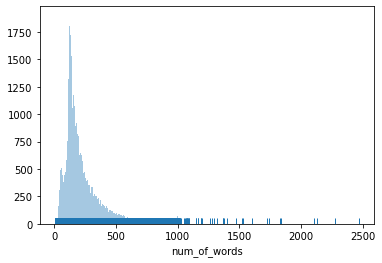

In [9]:
sb.distplot(data['num_of_words'], bins=500, kde=False, rug=True);

In [10]:
data[data['num_of_words']>500].describe()

,num_of_words
count,3903.000000
mean,688.627978
std,166.151119
min,501.000000
25%,560.000000
50%,643.000000
75%,785.000000
max,2470.000000


### Data preparation

In [73]:
# Summarizing reviews having more than 128 words
max_words = 200

def preprocess_text(review):
    review = re.sub("<.*?>"," ",review)
    review = review.strip()
    return review

def summary(review):
    # Summarize long reviews to max_words words
    result = summarize(review, words=max_words)
    return result


In [74]:
data["review_processed"] = data["review"].apply(lambda x:preprocess_text(x))
data['num_of_words'] = data['review_processed'].apply(lambda x:len(str(x).split()))
data["review_processed"]

0        One of the other reviewers has mentioned that ...
1        A wonderful little production.   The filming t...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review_processed, Length: 50000, dtype: object

In [75]:
large_reviews = data[data['num_of_words']>500]
large_reviews

,review,sentiment,review_list,num_of_words,review_processed,summarized_review
26,"""The Cell"" is an exotic masterpiece, a dizzyin...",positive,"[""The, Cell"", is, an, exotic, masterpiece,, a,...",564,"""The Cell"" is an exotic masterpiece, a dizzyin...","""The Cell"" is an exotic masterpiece, a dizzyin..."
29,'War movie' is a Hollywood genre that has been...,positive,"['War, movie', is, a, Hollywood, genre, that, ...",610,'War movie' is a Hollywood genre that has been...,"The Civil War-era ""Cold Mountain,"" starring Ju..."
33,One of the most significant quotes from the en...,positive,"[One, of, the, most, significant, quotes, from...",646,One of the most significant quotes from the en...,One of the most significant quotes from the en...
48,Preston Sturgis' THE POWER AND THE GLORY was u...,positive,"[Preston, Sturgis', THE, POWER, AND, THE, GLOR...",700,Preston Sturgis' THE POWER AND THE GLORY was u...,"Yes, like KANE it is about a legendary busines..."
51,"***SPOILERS*** All too, in real life as well a...",positive,"[***SPOILERS***, All, too,, in, real, life, as...",615,"***SPOILERS*** All too, in real life as well a...",Rose was really in love with Jimmy's good frie...
...,...,...,...,...,...,...
49948,"It is the early morning of our discontent, and...",negative,"[It, is, the, early, morning, of, our, discont...",977,"It is the early morning of our discontent, and...","With these provisos in mind, I would like to s..."
49954,Why is it that every time I mention this movie...,negative,"[Why, is, it, that, every, time, I, mention, t...",530,Why is it that every time I mention this movie...,Is that really what film has become?\nHow this...
49959,"My thoughts on the movie, 9<br /><br />It was ...",negative,"[My, thoughts, on, the, movie,, 9<br, /><br, /...",603,"My thoughts on the movie, 9 It was not good, ...","but ""souls"" have the power to destroy monsters..."
49960,John Carpenter's career is over if this sad ex...,negative,"[John, Carpenter's, career, is, over, if, this...",504,John Carpenter's career is over if this sad ex...,"In fact, Bon Jovi and the two Vampire girls, N..."


In [76]:
data["summarized_review"] = data.apply(lambda x:summary(x["review_processed"]) if x["num_of_words"]>max_words else x["review_processed"], axis=1)

data["summarized_review"]

0        One of the other reviewers has mentioned that ...
1        A wonderful little production.   The filming t...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am still a practicing Catholic but would not...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: summarized_review, Length: 50000, dtype: object

In [77]:
data[data['num_of_words']>2000]

,review,sentiment,review_list,num_of_words,review_processed,summarized_review
31240,"(Some spoilers included:)<br /><br />Although,...",positive,"[(Some, spoilers, included:)<br, /><br, />Alth...",2088,"(Some spoilers included:) Although, many comm...","To quote from Encyclopedia Britannica's, surre..."
31436,"Back in the mid/late 80s, an OAV anime by titl...",positive,"[Back, in, the, mid/late, 80s,, an, OAV, anime...",2111,"Back in the mid/late 80s, an OAV anime by titl...",4) Originally a short red haired girl who was ...
31481,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive,"[Match, 1:, Tag, Team, Table, Match, Bubba, Ra...",2459,Match 1: Tag Team Table Match Bubba Ray and Sp...,Winner: Bubba Ray and Spike Dudley Match 2: C...
40521,There's a sign on The Lost Highway that says:<...,positive,"[There's, a, sign, on, The, Lost, Highway, tha...",2235,There's a sign on The Lost Highway that says: ...,The main characters seen in the first half of ...


### Training

In [78]:
# Split dataset
x = data['summarized_review']
y = data['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=32, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=32, shuffle=True)

In [79]:
print('x train:',x_train.shape)
print('y train:',y_train.shape)
print('x val:',x_val.shape)
print('y val:',y_val.shape)
print('x test:',x_test.shape)
print('y test:',y_test.shape)

x train: (25000,)
y train: (25000,)
x val: (12500,)
y val: (12500,)
x test: (12500,)
y test: (12500,)


In [80]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_val = encoder.transform(y_val)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_val = np_utils.to_categorical(encoded_Y_val)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [81]:
x_val

46005    I liked this movie a lot, but the feeling that...
8313     Sydney Lumet, in this performance at the age o...
30894    This is the kind of movie that BEGS to be show...
36493    This film is superb! Wesley Snipes Plays Blade...
8523     The Wicker Man, starring Nicolas Cage, is by n...
                               ...                        
29524    Also titled--> The Magical Castle--> This one ...
41034    When I went to watch this movie my expectation...
7404     My definition of a great movie is if you want ...
4771     I love low budget movies. Including those that...
45301    I went through the highs. I went through the l...
Name: summarized_review, Length: 12500, dtype: object

In [82]:
y_val

46005    positive
8313     positive
30894    negative
36493    positive
8523     negative
           ...   
29524    negative
41034    positive
7404     positive
4771     negative
45301    positive
Name: sentiment, Length: 12500, dtype: object

In [52]:
# BERT model

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1",
                            trainable=True)


In [83]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [84]:
tokenizer = bert.tokenization.FullTokenizer(vocab_file, do_lower_case=True)
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids) 


['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [85]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])


[101, 102]

In [86]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

review = tf.ragged.constant([
    encode_sentence(s) for s in x_train])


In [87]:
print('Tokenized reviews shape', review.shape.as_list())

Tokenized reviews shape [25000, None]


In [88]:
x_train[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked.\nThe first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO.\nIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary.\nIt focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda.\nForget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around.\nThe first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence.\nNot just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being tur

In [89]:
tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
    print(i, tokenizer.convert_tokens_to_ids([i]))

one [2028]
of [1997]
the [1996]
other [2060]
reviewers [15814]
has [2038]
mentioned [3855]
that [2008]
after [2044]
watching [3666]
just [2074]
1 [1015]
oz [11472]
episode [2792]
you [2017]
' [1005]
ll [2222]
be [2022]
hooked [13322]
. [1012]
the [1996]
first [2034]
thing [2518]
that [2008]
struck [4930]
me [2033]
about [2055]
oz [11472]
was [2001]
its [2049]
brutality [24083]
and [1998]
un [4895]
##fl [10258]
##in [2378]
##ching [8450]
scenes [5019]
of [1997]
violence [4808]
, [1010]
which [2029]
set [2275]
in [1999]
right [2157]
from [2013]
the [1996]
word [2773]
go [2175]
. [1012]
it [2009]
is [2003]
called [2170]
oz [11472]
as [2004]
that [2008]
is [2003]
the [1996]
nickname [8367]
given [2445]
to [2000]
the [1996]
oswald [17411]
maximum [4555]
security [3036]
state [2110]
pen [7279]
##ite [4221]
##nta [12380]
##ry [2854]
. [1012]
it [2009]
focuses [7679]
mainly [3701]
on [2006]
emerald [14110]
city [2103]
, [1010]
an [2019]
experimental [6388]
section [2930]
of [1997]
the [1996]
p

#### Mask and input type

In [90]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*review.shape[0]
input_word_ids = tf.concat([cls, review], axis=-1)
input_mask = tf.ones_like(input_word_ids).to_tensor()


In [91]:
type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(review)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()

In [92]:
lens = [len(i) for i in input_word_ids]

In [93]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 480


In [94]:
# Wrapping up all in a function

def encode_names(n, tokenizer):
    tokens = list(tokenizer.tokenize(n))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
    num_examples = len(string_list)

    string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
    input_word_ids = tf.concat([cls, string_tokens], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

    type_cls = tf.zeros_like(cls)
    type_tokens = tf.ones_like(string_tokens)
    input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

In [95]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_val = bert_encode(x_val, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

#### Model

In [96]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")

inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
        }

intermediate_outputs = bert_layer(inputs)    
pooled_output = intermediate_outputs['pooled_output']

output = tf.keras.layers.Dropout(rate=0.4)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs=inputs,
        outputs=output)

In [101]:
epochs = 7
batch_size = 3  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [102]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 480)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 480)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 480)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      multiple             4782465     input_mask[0][0]                 
                                                                 input_type_ids[0][0]       

In [104]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, dummy_y_val),
                    verbose=1)

Epoch 1/7
8334/8334 [==============================] - 448s 53ms/step - loss: 0.5901 - accuracy: 0.8565 - val_loss: 0.6899 - val_accuracy: 0.8609
Epoch 2/7
8334/8334 [==============================] - 443s 53ms/step - loss: 0.5355 - accuracy: 0.8785 - val_loss: 0.6274 - val_accuracy: 0.8714
Epoch 3/7
8334/8334 [==============================] - 443s 53ms/step - loss: 0.4642 - accuracy: 0.9009 - val_loss: 0.6353 - val_accuracy: 0.8767
Epoch 4/7
8334/8334 [==============================] - 443s 53ms/step - loss: 0.3967 - accuracy: 0.9181 - val_loss: 0.6751 - val_accuracy: 0.8772
Epoch 5/7
8334/8334 [==============================] - 443s 53ms/step - loss: 0.3464 - accuracy: 0.9316 - val_loss: 0.6586 - val_accuracy: 0.8806
Epoch 6/7
8334/8334 [==============================] - 440s 53ms/step - loss: 0.3162 - accuracy: 0.9407 - val_loss: 0.7289 - val_accuracy: 0.8803
Epoch 7/7
8334/8334 [==============================] - 443s 53ms/step - loss: 0.2777 - accuracy: 0.9478 - val_loss: 0.7289 -

In [105]:
# Testing accuracy
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8830


In [106]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

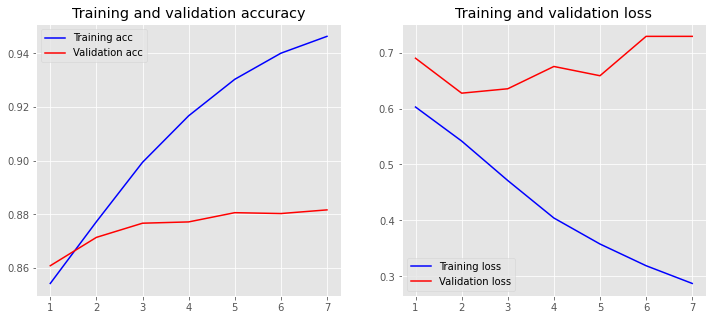

In [107]:
plot_history(history)

In [108]:
# Saving fine tuned model
model.save('large_doc_clasiffier_bert_small_L4_H128_A-2/1')

INFO:tensorflow:Assets written to: large_doc_clasiffier_bert_small_L4_H128_A-2/1\assets


INFO:tensorflow:Assets written to: large_doc_clasiffier_bert_small_L4_H128_A-2/1\assets


### Let's test the model

In [152]:
for review in x_test[0:10]:
    print()
    print(review)
    print("===============")
    


Although many audio recordings of great musicians like Jascha Heifetz survive, the cinematic or televised record is limited indeed.
This is why musical offerings like "They Shall Have Music" are such rare gems.
A important aspect of the experience of watching classic films is to see them through the eyes of the moviegoer of that era.
I must take issue with reviewer who complains about a film that is in black and white, or who feel obliged to report that their students express such reservations.
For example, the black and white photography of John Ford's "Stagecoach," is, like the still photographs of Ansel Adams, an artistic masterpiece.
The role of a classical musician like Heifetz is to move the audience, not him or herself.
Heifetz's emotion is conveyed through his playing, not through his body language.
He had a rare ability to extract every emotional nuance out of the music and transfer it to his listeners.
This is from the 1947 film "Carnegie Hall," not "They Shall Have Music" "

In [145]:
text = """jim carrey can do anything. i thought this was going to be some dumb childish movie, and it TOTALLY was not. it was so incredibly funny for EVERYONE, adults & kids. i saw it once cause it was almost out of theatres, and now it's FINALLY coming out on DVD this tuesday and i'm way to excited, as you can see. you should definitely see it if you haven't already, it was so great!  Liz"""

encoded_text = bert_encode([text], tokenizer, max_seq_length)

In [146]:
result = model.predict(encoded_text)

In [147]:
encoder.classes_

array(['negative', 'positive'], dtype=object)

In [148]:
print(result)
print('Review is', 'positive' if encoder.classes_[np.argmax(result)]=='positive' else 'negative')

[[4.378137e-04 9.995622e-01]]
Review is positive


In [153]:
text2 = """
This is a terrible film. Angie Dickenson is a class act and always does well, but she does not get many roles any more and she must have needed some money to do this film. By the way, she is on screen less than 10 minutes. 
Oooh, wait, there is one redeeming feature in this film: Meg Foster has a small part in this film.
Now, Meg has been on the screen for 35 years and is not particularly great but she has the scariest eyes of any actress I have ever seen. By name, you probably don't know her, but one look at her eyes and you will recognize her. To summarize: the acting is horrid, the story bad, and even the filmography is dreadful. 
A screen going to black every time the director wants to change scenes is pretty moronic. 
Watch any thing else but this, even Mr Ed reruns!
"""

encoded_text2 = bert_encode([text2], tokenizer, max_seq_length)

In [154]:
result2 = model.predict(encoded_text2)

In [155]:
print(result2)
print('Review is', 'positive' if encoder.classes_[np.argmax(result2)]=='positive' else 'negative')

[[9.9978501e-01 2.1496088e-04]]
Review is negative
